In [12]:
from astropy.table import Table
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
from multiprocessing import Pool
import os
from scipy.stats import gaussian_kde
from IPython.display import display, Math
import matplotlib.pyplot as plt
import pymc3 as pm
import corner

In [13]:
table = Table.read('outerdisk_sample.fits')
table.info

<Table length=23983>
       name        dtype    unit     class     n_bad
----------------- ------- ------- ------------ -----
             teff float32       K       Column     0
         teff_err float32       K       Column     0
              feh float32               Column     0
          feh_err float32               Column     0
               rv float32  km / s       Column     0
           rv_err float32  km / s       Column     0
             glon float64 degrees       Column     0
             glat float64 degrees       Column     0
     distK50_RJCE float64  parsec MaskedColumn   359
     distK15_RJCE float64  parsec MaskedColumn   359
     distK85_RJCE float64  parsec MaskedColumn   359
                X float64     kpc MaskedColumn   359
                Y float64     kpc MaskedColumn   359
                Z float64     kpc MaskedColumn   359
              Rgc float64     kpc MaskedColumn   359
             r_gc float64     kpc MaskedColumn   359
              PHI float64

In [14]:
feh_raw = table['feh']
feh_err_raw = table['feh_err']
Rgc_raw = table['Rgc']
Rgc_err_raw = np.abs(table['Rgc']-8.34) * 0.2

masked = ~Rgc_err_raw.data.mask

feh = np.asarray(feh_raw[masked])
feh_err = np.asarray(feh_err_raw[masked])
Rgc = np.asarray(Rgc_raw[masked])
Rgc_err = np.asarray(Rgc_err_raw[masked])

In [15]:
# table

In [20]:
np.random.seed(0)
R = np.linspace(0, 10, len(feh))
def fun_feh(R, model_slope, model_z0):
    return model_slope*(R)+model_z0

In [24]:
# 定义模型
with pm.Model() as model:
    
#全局变量
    model_slope_group = -pm.HalfNormal("model_slope_group", sigma=3)
    model_slope_err_group = pm.HalfNormal("model_slope_err_group", sigma=3)
    model_z0_group = pm.Normal("model_z0_group",0, sigma=3)
    model_z0_err_group = pm.HalfNormal("model_z0_err_group", sigma=3)
#层级变量（主干变量）
    model_slope_global = pm.Normal("model_slope_global",model_slope_group, sigma=model_slope_err_group)
    model_z0_global = pm.Normal("model_z0_global", mu=model_z0_group, sigma=model_z0_err_group)
    sigma_feh_global = pm.HalfNormal("sigma_feh_global", sigma=2)
    Ri = pm.Normal('Ri', Rgc, Rgc_err, observed=Rgc)
    sigma_global = pm.HalfNormal("sigma_global", sigma=2)

    # 数据生成模型
    mu = fun_feh(Ri, model_slope_global, model_z0_global)
    # likelihood = feh_obs
    likelihood = pm.Normal("Fe/H", mu, sigma=np.sqrt(sigma_global**2+feh_err**2), observed=feh)
    # 采样后验分布
    trace = pm.sample(2000, tune=1000, cores=2)



/Users/liaojie/anaconda3/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_global, sigma_feh_global, model_z0_global, model_slope_global, model_z0_err_group, model_z0_group, model_slope_err_group, model_slope_group]


/Users/liaojie/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/liaojie/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 75 seconds.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


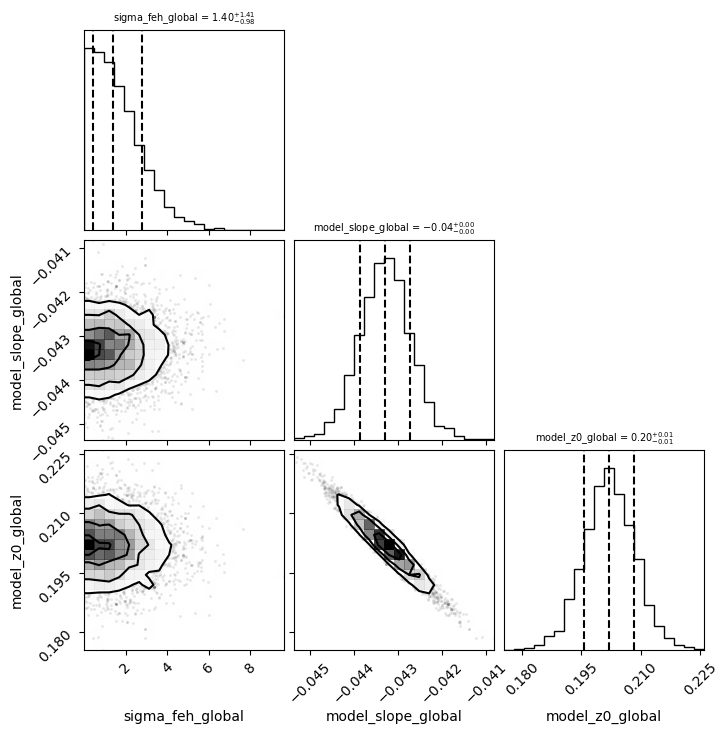

In [25]:
# 提取后验分布样本
posterior_samples = pm.trace_to_dataframe(trace)

# 绘制corner图
var_names = ["sigma_feh_global","model_slope_global", "model_z0_global"]
samples = posterior_samples[var_names].values
corner.corner(samples, labels=var_names, quantiles=[0.16, 0.5, 0.84],
              show_titles=True, title_kwargs={"fontsize": 7})
plt.show()

/Users/liaojie/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


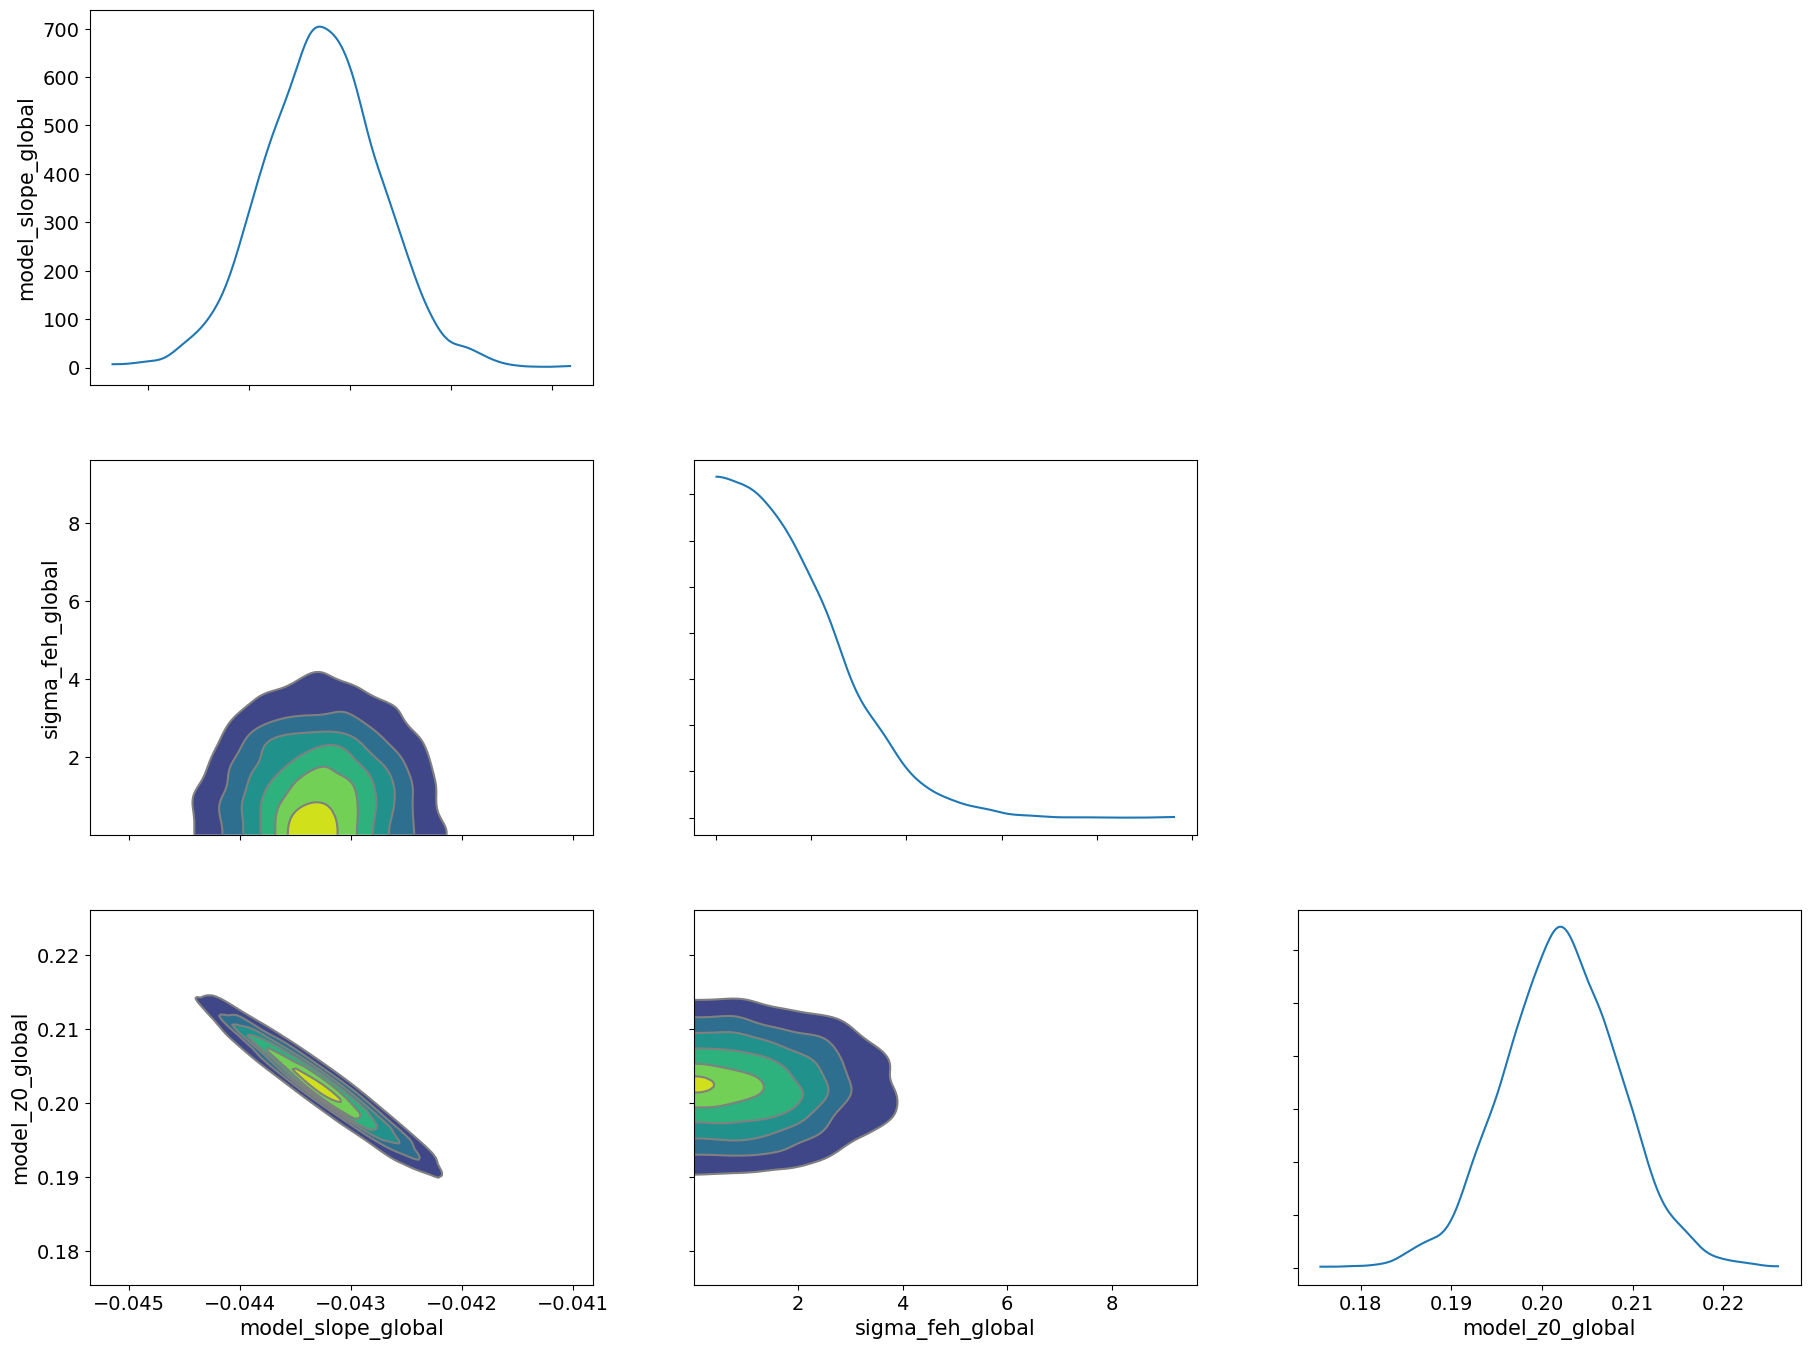

In [26]:
import arviz as az
az.plot_pair(trace, var_names=['model_slope_global','sigma_feh_global',
                               'model_z0_global'], kind="kde", marginals=True, divergences=False);